In [4]:
import pandas as pd
import nltk
from nltk import FreqDist
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ModuleNotFoundError: No module named 'pyLDAvis'

In [2]:
like = pd.read_excel('/Users/reggieyang/Desktop/Python/Summer Projects/NLP/like.xlsx')

In [3]:
column_name = like.columns[0]
like.rename({column_name:'like_review'},axis=1,inplace=True)


In [4]:
# Apply text cleaning using regular expression
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

tc = lambda x: clean_text(x)

# Let's take a look at the updated text
data_clean = pd.DataFrame(like.like_review.apply(tc))
data_clean.head()

<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<ipython-input-4-f073003bdb1b>:8: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-4-f073003bdb1b>:10: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


,like_review
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...
1,science articles product reviews science news and historical articles
2,the variety of hot topics and the historical tidbits
3,keeps me up to date and exposes me to new research
4,i like the discovery news and the articles on environmental issues


In [5]:
#Remove stop words
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.append('articles')
stop_words.append('article')

data_clean['reviews_without_stopwords'] = data_clean['like_review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_clean.head()

,like_review,reviews_without_stopwords
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new things outside field inspired cutting edge advances theory experiment love read cover cover caught nov issue yet subject survey
1,science articles product reviews science news and historical articles,science product reviews science news historical
2,the variety of hot topics and the historical tidbits,variety hot topics historical tidbits
3,keeps me up to date and exposes me to new research,keeps date exposes new research
4,i like the discovery news and the articles on environmental issues,like discovery news environmental issues


In [6]:
#Lemmatize data
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
def to_string(df):
    return ' '.join(df)

data_clean['text_lemmatized'] = data_clean.reviews_without_stopwords.apply(lemmatize_text)
data_clean['text_lemmatized'] = data_clean['text_lemmatized'].map(to_string)

data_clean.head()
#data_clean.to_csv('/Users/reggieyang/Desktop/Python/Summer Projects/NLP/dataset/like_data_clean.csv',index=False)

,like_review,reviews_without_stopwords,text_lemmatized
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new things outside field inspired cutting edge advances theory experiment love read cover cover caught nov issue yet subject survey,learning new thing outside field inspired cutting edge advance theory experiment love read cover cover caught nov issue yet subject survey
1,science articles product reviews science news and historical articles,science product reviews science news historical,science product review science news historical
2,the variety of hot topics and the historical tidbits,variety hot topics historical tidbits,variety hot topic historical tidbit
3,keeps me up to date and exposes me to new research,keeps date exposes new research,keep date expose new research
4,i like the discovery news and the articles on environmental issues,like discovery news environmental issues,like discovery news environmental issue


In [7]:
data_clean.head()

,like_review,reviews_without_stopwords,text_lemmatized
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new things outside field inspired cutting edge advances theory experiment love read cover cover caught nov issue yet subject survey,learning new thing outside field inspired cutting edge advance theory experiment love read cover cover caught nov issue yet subject survey
1,science articles product reviews science news and historical articles,science product reviews science news historical,science product review science news historical
2,the variety of hot topics and the historical tidbits,variety hot topics historical tidbits,variety hot topic historical tidbit
3,keeps me up to date and exposes me to new research,keeps date exposes new research,keep date expose new research
4,i like the discovery news and the articles on environmental issues,like discovery news environmental issues,like discovery news environmental issue


# Data Modeling & Data Visulization 

In [8]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

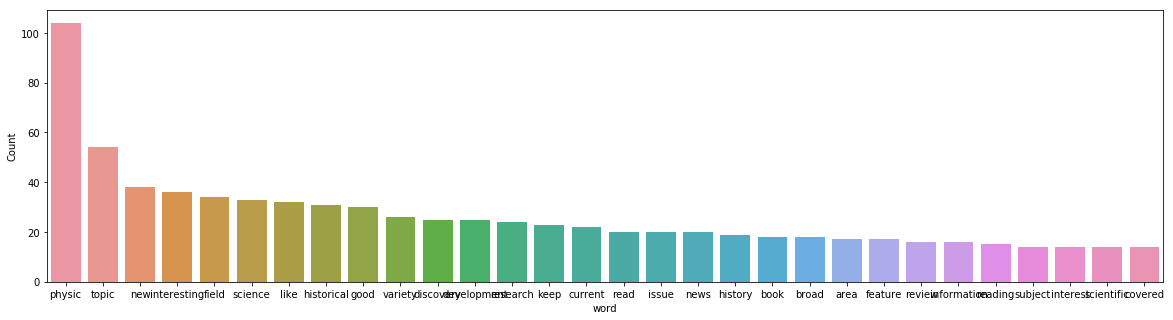

In [9]:
freq_words(data_clean['text_lemmatized'])

## Building an LDA model


In [10]:
review = [word for word in data_clean['text_lemmatized']]

In [11]:
tokenized_reviews = pd.Series(review).apply(lambda x: x.split())

In [12]:
dictionary = corpora.Dictionary(tokenized_reviews)

In [13]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]


In [14]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [15]:
lda_model.print_topics()

[(0,
  '0.038*"broad" + 0.033*"topic" + 0.031*"physic" + 0.023*"historical" + 0.013*"range" + 0.011*"science" + 0.011*"much" + 0.010*"enjoy" + 0.009*"good" + 0.009*"outside"'),
 (1,
  '0.048*"physic" + 0.033*"like" + 0.020*"history" + 0.017*"today" + 0.015*"science" + 0.014*"physicist" + 0.012*"new" + 0.012*"field" + 0.012*"discovery" + 0.011*"topic"'),
 (2,
  '0.030*"physic" + 0.017*"subject" + 0.014*"read" + 0.012*"new" + 0.012*"detail" + 0.012*"good" + 0.011*"level" + 0.009*"well" + 0.009*"diversity" + 0.009*"idea"'),
 (3,
  '0.048*"good" + 0.033*"variety" + 0.031*"field" + 0.025*"news" + 0.025*"research" + 0.022*"review" + 0.017*"science" + 0.016*"letter" + 0.014*"book" + 0.014*"scientific"'),
 (4,
  '0.040*"topic" + 0.029*"discovery" + 0.023*"book" + 0.023*"variety" + 0.023*"feature" + 0.023*"new" + 0.021*"search" + 0.012*"covered" + 0.011*"job" + 0.011*"review"'),
 (5,
  '0.060*"physic" + 0.046*"interesting" + 0.020*"area" + 0.020*"keep" + 0.017*"current" + 0.016*"topic" + 0.014*

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/reggieyang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.100199 -0.068005       1        1  18.085398
5     -0.008056  0.176258       2        1  17.370001
4     -0.099522 -0.076164       3        1  16.422785
0      0.078171  0.023925       4        1  14.707379
1      0.034318  0.001305       5        1  12.454125
3     -0.141817 -0.004721       6        1  10.511127
2      0.036706 -0.052598       7        1  10.449186, topic_info=    Category       Freq           Term      Total  loglift  logprob
190  Default  14.000000          broad  14.000000  30.0000  30.0000
81   Default  22.000000           good  22.000000  29.0000  29.0000
28   Default  19.000000        variety  19.000000  28.0000  28.0000
97   Default  28.000000    interesting  28.000000  27.0000  27.0000
48   Default  80.000000         physic  80.000000  26.0000  26.0000
33   Default  19.000000      discovery  19.000000  25.0000  25.0000
27   Default  41.000000          topic  41.000000  24.0000  24.0000
160  Default  14.000000           book  14.000000  23.0000  23.0000
302  Default   9.000000         search   9.000000  22.0000  22.0000
23   Default  12.000000         review  12.000000  21.0000  21.0000
21   Default  15.000000           news  15.000000  20.0000  20.0000
35   Default  25.000000           like  25.000000  19.0000  19.0000
170  Default  13.000000        feature  13.000000  18.0000  18.0000
88   Default  13.000000           area  13.000000  17.0000  17.0000
6    Default  26.000000          field  26.000000  16.0000  16.0000
222  Default   8.000000        general   8.000000  15.0000  15.0000
31   Default  18.000000           keep  18.000000  14.0000  14.0000
32   Default  18.000000       research  18.000000  13.0000  13.0000
96   Default  15.000000        history  15.000000  12.0000  12.0000
145  Default   8.000000          today   8.000000  11.0000  11.0000
220  Default   7.000000         letter   7.000000  10.0000  10.0000
20   Default  24.000000     historical  24.000000   9.0000   9.0000
45   Default   6.000000           much   6.000000   8.0000   8.0000
29   Default   9.000000           date   9.000000   7.0000   7.0000
11   Default  29.000000            new  29.000000   6.0000   6.0000
193  Default   7.000000          study   7.000000   5.0000   5.0000
64   Default  10.000000       coverage  10.000000   4.0000   4.0000
15   Default  11.000000        subject  11.000000   3.0000   3.0000
24   Default  25.000000        science  25.000000   2.0000   2.0000
14   Default  16.000000           read  16.000000   1.0000   1.0000
..       ...        ...            ...        ...      ...      ...
188   Topic7   1.559456      published   2.973983   1.6131  -5.1102
464   Topic7   1.558631         result   3.023580   1.5960  -5.1107
15    Topic7   4.469438        subject  11.240406   1.3364  -4.0573
54    Topic7   2.285693  undergraduate   5.379351   1.4027  -4.7279
185   Topic7   2.286325          going   6.045180   1.2863  -4.7276
240   Topic7   1.558602          world   3.739009   1.3836  -5.1108
45    Topic7   2.285720           much   6.759838   1.1743  -4.7279
248   Topic7   2.889742          level   9.720177   1.0456  -4.4934
98    Topic7   2.227304    opportunity   6.697030   1.1578  -4.7537
14    Topic7   3.594652           read  16.207836   0.7526  -4.2751
149   Topic7   1.558633       material   4.481145   1.2026  -5.1107
48    Topic7   7.796003         physic  80.473366  -0.0757  -3.5009
52    Topic7   2.286154          story   9.108050   0.8764  -4.7277
56    Topic7   2.286946           well   9.169231   0.8700  -4.7273
142   Topic7   1.558376        quality   5.107111   1.0717  -5.1109
79    Topic7   1.558540       magazine   5.367052   1.0221  -5.1108
81    Topic7   3.012844           good  22.594124   0.2438  -4.4517
11    Topic7   3.113917            new  29.969286  -0.0056  -4.4187
21    Topic7   2.286314           news  15.369339   0.3532  -4.7276
95 

In [17]:
corpus_transformed = lda_model[doc_term_matrix]
from operator import itemgetter
score_list = []
for topic in corpus_transformed:
        score_list.append(max(topic,key=itemgetter(1)))
data_clean['topic_score'] = score_list

In [18]:
data_clean

,like_review,reviews_without_stopwords,text_lemmatized,topic_score
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,learning new things outside field inspired cutting edge advances theory experiment love read cover cover caught nov issue yet subject survey,learning new thing outside field inspired cutting edge advance theory experiment love read cover cover caught nov issue yet subject survey,"(6, 0.9609344)"
1,science articles product reviews science news and historical articles,science product reviews science news historical,science product review science news historical,"(3, 0.8773516)"
2,the variety of hot topics and the historical tidbits,variety hot topics historical tidbits,variety hot topic historical tidbit,"(4, 0.85686505)"
3,keeps me up to date and exposes me to new research,keeps date exposes new research,keep date expose new research,"(5, 0.46460897)"
4,i like the discovery news and the articles on environmental issues,like discovery news environmental issues,like discovery news environmental issue,"(4, 0.85647917)"
5,the historical articles,historical,historical,"(0, 0.57061136)"
6,it brings me easy to read news about physics and related fields with enough technical detail to interest me as a professional the stories are often well enough explained for a layman as well so m...,brings easy read news physics related fields enough technical detail interest professional stories often well enough explained layman well much use undergraduate classes occasionally send friends,brings easy read news physic related field enough technical detail interest professional story often well enough explained layman well much use undergraduate class occasionally send friend,"(2, 0.9681846)"
7,variety of subjects,variety subjects,variety subject,"(2, 0.40705785)"
8,i like most when others use it to teach folks like me their subject matter i want to learn some physics,like others use teach folks like subject matter want learn physics,like others use teach folk like subject matter want learn physic,"(1, 0.9284626)"
9,breadth of coverage,breadth coverage,breadth coverage,"(5, 0.7141145)"


In [19]:
#count each topic
def extract_topic(df):
    if df[1]<0.6:
        return 7
    else:
        return df[0]
data_clean['topic'] = data_clean['topic_score'].apply(extract_topic)

#add column with topic content
def add_content(df):
    if int(df)==7:
        return 'Others'
    else:
        return lda_model.print_topics()[int(df)]
data_clean['topic_content'] = data_clean['topic'].apply(add_content)

In [20]:
topic_dic = {0:'broad topic',1:'history new discovery',2:'subject, detail, level',3:'variety',
             4:'discovery feature',5:'topic coverage',6:'new science development',7:'Others'}
data_clean['topic_content2'] = data_clean['topic'].map(topic_dic)

In [21]:
data_clean = data_clean[['like_review','topic_score','topic','topic_content','topic_content2']]
data_clean

,like_review,topic_score,topic,topic_content,topic_content2
0,learning new things outside my field and being inspired by cutting edge advances in theory or experiment love to read it cover to cover but had not caught up to the nov issue yet subject of this...,"(6, 0.9609344)",6,"(6, 0.038*""physic"" + 0.020*""new"" + 0.016*""science"" + 0.015*""development"" + 0.015*""field"" + 0.015*""read"" + 0.013*""issue"" + 0.011*""keep"" + 0.011*""like"" + 0.011*""cover"")",new science development
1,science articles product reviews science news and historical articles,"(3, 0.8773516)",3,"(3, 0.048*""good"" + 0.033*""variety"" + 0.031*""field"" + 0.025*""news"" + 0.025*""research"" + 0.022*""review"" + 0.017*""science"" + 0.016*""letter"" + 0.014*""book"" + 0.014*""scientific"")",variety
2,the variety of hot topics and the historical tidbits,"(4, 0.85686505)",4,"(4, 0.040*""topic"" + 0.029*""discovery"" + 0.023*""book"" + 0.023*""variety"" + 0.023*""feature"" + 0.023*""new"" + 0.021*""search"" + 0.012*""covered"" + 0.011*""job"" + 0.011*""review"")",discovery feature
3,keeps me up to date and exposes me to new research,"(5, 0.46460897)",7,Others,Others
4,i like the discovery news and the articles on environmental issues,"(4, 0.85647917)",4,"(4, 0.040*""topic"" + 0.029*""discovery"" + 0.023*""book"" + 0.023*""variety"" + 0.023*""feature"" + 0.023*""new"" + 0.021*""search"" + 0.012*""covered"" + 0.011*""job"" + 0.011*""review"")",discovery feature
5,the historical articles,"(0, 0.57061136)",7,Others,Others
6,it brings me easy to read news about physics and related fields with enough technical detail to interest me as a professional the stories are often well enough explained for a layman as well so m...,"(2, 0.9681846)",2,"(2, 0.030*""physic"" + 0.017*""subject"" + 0.014*""read"" + 0.012*""new"" + 0.012*""detail"" + 0.012*""good"" + 0.011*""level"" + 0.009*""well"" + 0.009*""diversity"" + 0.009*""idea"")","subject, detail, level"
7,variety of subjects,"(2, 0.40705785)",7,Others,Others
8,i like most when others use it to teach folks like me their subject matter i want to learn some physics,"(1, 0.9284626)",1,"(1, 0.048*""physic"" + 0.033*""like"" + 0.020*""history"" + 0.017*""today"" + 0.015*""science"" + 0.014*""physicist"" + 0.012*""new"" + 0.012*""field"" + 0.012*""discovery"" + 0.011*""topic"")",history new discovery
9,breadth of coverage,"(5, 0.7141145)",5,"(5, 0.060*""physic"" + 0.046*""interesting"" + 0.020*""area"" + 0.020*""keep"" + 0.017*""current"" + 0.016*""topic"" + 0.014*""coverage"" + 0.014*""date"" + 0.013*""historical"" + 0.013*""study"")",topic coverage


In [24]:
data_clean.to_excel('/Users/reggieyang/Desktop/Python/Summer Projects/NLP/final report/like_result.xlsx')

In [27]:
data_clean['topic'].value_counts()

7    80
5    63
4    60
0    44
1    39
6    37
3    37
2    32
Name: topic, dtype: int64